# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_060  Q93091           17.541
Sample_170  A2NJV5           22.542
Sample_096  P43121           16.936
Sample_149  Q9Y5Y7           19.210
Sample_128  P68371           12.191
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups 
Sample_064  P15531;P15531-2   12.893
Sample_115  C9J712;P35080     13.488
Sample_075  P01912;Q5Y7A7     16.000
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.962
            A0A075B6Q5                 13.061
            A0A075B6R2                 12.828
            A0A075B6S5                 10.986
            A0A087WSY4                 12.399
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.542
            Q9UI40;Q9UI40-2            11.391
            Q9UIW2                     12.548
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.014
            Q9UP79                     12.884
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.905,15.050,16.842,19.863,15.519,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.815,19.067,...,15.528,15.576,14.206,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.610,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.689,17.705,17.039,16.188,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.877,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.608,15.345,17.084,18.708,14.249,19.433,12.273,11.377
Sample_207,15.739,16.877,15.469,16.898,14.521,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.361,13.978,12.580,14.224,15.291,13.080,12.068,13.525,12.124,12.227
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.682,19.067,16.127,...,11.848,12.569,12.841,12.007,12.731,13.606,13.624,14.005,12.330,13.049
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.670,13.626,12.483,11.618,12.653,14.085,13.062,12.290,12.730,12.559
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.716,13.077,13.458,12.510,12.759,13.074,12.733,13.107,12.275,13.376
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.671,11.019,13.077,13.600,12.935,12.161,13.489,13.609,13.682,13.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.615,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 77.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.70it/s]

100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.46it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.38it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.82it/s]

100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.15it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.22it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.95it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.05it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.81it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.54it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.50it/s]

100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.75it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.79it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.51it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.36it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.40it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.49it/s]

100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.76it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.67it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.59it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.51it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.48it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.38it/s]

100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.84it/s]

 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

 40%|████      | 4/10 [00:01<00:01,  3.41it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.31it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.25it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.35it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.51it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.59it/s]

100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.95it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.66it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.56it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.52it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.59it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.70it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.66it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.70it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.74it/s]

100%|██████████| 11/11 [00:02<00:00,  3.81it/s]

100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.70it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.80it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.44it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.99it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.83it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.95it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.15it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.28it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.31it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.49it/s]

100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.61it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.22it/s]

 31%|███       | 4/13 [00:01<00:03,  2.70it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.59it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.77it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  3.09it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.22it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.22it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.29it/s]

100%|██████████| 13/13 [00:04<00:00,  3.39it/s]

100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.44it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.85it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.26it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.98it/s]

 43%|████▎     | 6/14 [00:01<00:03,  2.60it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.44it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.40it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.46it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.47it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.81it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.03it/s]

100%|██████████| 14/14 [00:04<00:00,  3.17it/s]

100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.99it/s]

 20%|██        | 3/15 [00:00<00:02,  4.91it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.65it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.11it/s]

 40%|████      | 6/15 [00:01<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.97it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.93it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.93it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.92it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.03it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.17it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.27it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.34it/s]

100%|██████████| 15/15 [00:04<00:00,  2.93it/s]

100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.042 0.015          0.877 0.203       0.160   
2             0.003 0.000      0.039 0.004          0.673 0.120       0.555   
3             0.004 0.001      0.039 0.006          0.698 0.109       0.646   
4             0.004 0.001      0.039 0.003          0.723 0.098       0.676   
5             0.004 0.001      0.038 0.002          0.714 0.093       0.685   
6             0.004 0.001      0.040 0.008          0.819 0.076       0.816   
7             0.004 0.002      0.040 0.009          0.825 0.077       0.823   
8             0.004 0.001      0.040 0.005          0.822 0.079       0.816   
9             0.004 0.000      0.039 0.004          0.820 0.080       0.809   
10            0.003 0.001      0.033 0.008          0.811 0.091       0.798   
11            0.004 0.001      0.038 0.005          0.821 0.094       0.823   
12            0.006 0.003      0.056 0.021          0.821 0.085       0.832   
13            0.006 0.002      0.056 0.024          0.819 0.084       0.830   
14            0.004 0.001      0.042 0.012          0.826 0.082       0.818   
15            0.005 0.002      0.057 0.023          0.821 0.085       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.261 0.123                  0.572 0.042        0.865   
2          0.108   0.601 0.087                  0.675 0.065        0.732   
3          0.125   0.663 0.092                  0.716 0.074        0.804   
4          0.116   0.692 0.083                  0.740 0.066        0.838   
5          0.111   0.693 0.079                  0.740 0.064        0.830   
6          0.102   0.813 0.067                  0.841 0.055        0.906   
7          0.100   0.820 0.066                  0.846 0.055        0.905   
8          0.106   0.814 0.069                  0.842 0.057        0.903   
9          0.107   0.810 0.069                  0.838 0.058        0.902   
10         0.103   0.799 0.073                  0.829 0.061        0.902   
11         0.095   0.817 0.071                  0.843 0.061        0.913   
12         0.094   0.823 0.068                  0.848 0.059        0.915   
13         0.094   0.821 0.069                  0.846 0.060        0.915   
14         0.086   0.819 0.066                  0.845 0.057        0.919   
15         0.086   0.814 0.068                  0.841 0.059        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.089        210.000 0.000  
2          0.077                  0.691 0.097        210.000 0.000  
3          0.074                  0.734 0.097        210.000 0.000  
4          0.062                  0.800 0.085        210.000 0.000  
5          0.055                  0.788 0.084        210.000 0.000  
6          0.044                  0.882 0.057        210.000 0.000  
7          0.047                  0.881 0.056        210.000 0.000  
8          0.046                  0.879 0.055        210.000 0.000  
9          0.047                  0.876 0.058        210.000 0.000  
10         0.048                  0.878 0.057        210.000 0.000  
11         0.047                  0.899 0.051        210.000 0.000  
12         0.047                  0.903 0.051        210.000 0.000  
13         0.047                  0.903 0.050        210.000 0.000  
14         0.045                  0.909 0.047        210.000 0.000  
15         0.045                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 537.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.25it/s]

100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.01it/s]

100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.39it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.96it/s]

100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.84it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.66it/s]

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.22it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.78it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.46it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.52it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.46it/s]

100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.91it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.88it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.40it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.20it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.34it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.39it/s]

100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

100%|██████████| 8/8 [00:03<00:00,  2.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.90it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.48it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.80it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.50it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.22it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.21it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.87it/s]

 30%|███       | 3/10 [00:00<00:01,  4.96it/s]

 40%|████      | 4/10 [00:00<00:01,  3.67it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.51it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.75it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.43it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.42it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.47it/s]

100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.40it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.40it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.84it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.53it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.36it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.94it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.73it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.47it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.35it/s]

100%|██████████| 11/11 [00:03<00:00,  2.31it/s]

100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.71it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.18it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.66it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.27it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.21it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.13it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.03it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.98it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.63it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.44it/s]

100%|██████████| 12/12 [00:04<00:00,  2.29it/s]

100%|██████████| 12/12 [00:04<00:00,  2.86it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.87it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.03it/s]

 31%|███       | 4/13 [00:01<00:03,  2.74it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.61it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.68it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.77it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.80it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.84it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.93it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.12it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.21it/s]

100%|██████████| 13/13 [00:04<00:00,  3.32it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.55it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.79it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.50it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.81it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.38it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.32it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.27it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.40it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.56it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.73it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.97it/s]

100%|██████████| 14/14 [00:05<00:00,  3.01it/s]

100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.03it/s]

 20%|██        | 3/15 [00:00<00:03,  3.37it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.22it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.14it/s]

 40%|████      | 6/15 [00:01<00:02,  3.12it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.08it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.06it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.96it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.09it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.03it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.03it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.15it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:04<00:00,  2.75it/s]

100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.004      0.068 0.031          0.000 0.000       0.000   
2             0.005 0.002      0.057 0.021          0.659 0.109       0.592   
3             0.005 0.002      0.059 0.020          0.680 0.106       0.598   
4             0.004 0.002      0.045 0.016          0.674 0.102       0.593   
5             0.004 0.001      0.040 0.009          0.746 0.101       0.686   
6             0.004 0.001      0.041 0.011          0.757 0.080       0.711   
7             0.004 0.001      0.041 0.012          0.755 0.082       0.704   
8             0.005 0.002      0.052 0.019          0.753 0.084       0.706   
9             0.006 0.002      0.056 0.019          0.753 0.087       0.695   
10            0.006 0.003      0.054 0.020          0.827 0.085       0.796   
11            0.006 0.003      0.057 0.021          0.818 0.088       0.802   
12            0.005 0.002      0.048 0.018          0.817 0.088       0.789   
13            0.007 0.003      0.066 0.023          0.833 0.081       0.800   
14            0.005 0.002      0.045 0.014          0.833 0.080       0.798   
15            0.005 0.002      0.054 0.019          0.819 0.082       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.852   
2          0.105   0.619 0.091                  0.682 0.071        0.781   
3          0.109   0.630 0.090                  0.693 0.068        0.783   
4          0.109   0.625 0.089                  0.689 0.067        0.778   
5          0.101   0.710 0.083                  0.756 0.066        0.825   
6          0.107   0.729 0.082                  0.772 0.063        0.830   
7          0.099   0.725 0.077                  0.768 0.061        0.830   
8          0.098   0.725 0.076                  0.768 0.060        0.829   
9          0.103   0.719 0.081                  0.764 0.063        0.825   
10         0.095   0.807 0.069                  0.836 0.057        0.910   
11         0.104   0.806 0.079                  0.835 0.066        0.910   
12         0.112   0.797 0.079                  0.828 0.065        0.916   
13         0.098   0.813 0.072                  0.841 0.061        0.922   
14         0.099   0.811 0.071                  0.840 0.059        0.922   
15         0.101   0.805 0.072                  0.834 0.060        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.087        210.000 0.000  
2          0.067                  0.733 0.096        210.000 0.000  
3          0.066                  0.739 0.096        210.000 0.000  
4          0.066                  0.735 0.096        210.000 0.000  
5          0.063                  0.796 0.080        210.000 0.000  
6          0.064                  0.798 0.083        210.000 0.000  
7          0.064                  0.794 0.082        210.000 0.000  
8          0.065                  0.795 0.084        210.000 0.000  
9          0.065                  0.789 0.084        210.000 0.000  
10         0.049                  0.887 0.056        210.000 0.000  
11         0.049                  0.890 0.055        210.000 0.000  
12         0.045                  0.894 0.054        210.000 0.000  
13         0.044                  0.904 0.050        210.000 0.000  
14         0.046                  0.905 0.051        210.000 0.000  
15         0.046                  0.903 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 527.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.86it/s]

100%|██████████| 2/2 [00:00<00:00, 19.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.86it/s]

100%|██████████| 3/3 [00:00<00:00, 23.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.41it/s]

100%|██████████| 4/4 [00:00<00:00, 15.74it/s]

100%|██████████| 4/4 [00:00<00:00, 16.06it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.61it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.10it/s]

100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.64it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.44it/s]

100%|██████████| 6/6 [00:00<00:00, 13.99it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.73it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.90it/s]

100%|██████████| 7/7 [00:00<00:00, 16.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 15.80it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.51it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 13.27it/s]

100%|██████████| 8/8 [00:00<00:00, 12.43it/s]

100%|██████████| 8/8 [00:00<00:00, 12.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 16.48it/s]

 44%|████▍     | 4/9 [00:00<00:00, 11.54it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.08it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.03it/s]

100%|██████████| 9/9 [00:00<00:00, 11.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.44it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.01it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.56it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.91it/s]

100%|██████████| 10/10 [00:00<00:00, 12.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.79it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.11it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 17.63it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.06it/s]

100%|██████████| 11/11 [00:00<00:00, 14.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 14.80it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.89it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.17it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.31it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.56it/s]

100%|██████████| 12/12 [00:01<00:00, 11.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.95it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.26it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.59it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.10it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.74it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.62it/s]

100%|██████████| 13/13 [00:01<00:00,  8.24it/s]

100%|██████████| 13/13 [00:01<00:00,  9.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.86it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.63it/s]

 43%|████▎     | 6/14 [00:00<00:00,  8.91it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.99it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  7.56it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.32it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.33it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.22it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.60it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.10it/s]

100%|██████████| 14/14 [00:01<00:00,  7.96it/s]

100%|██████████| 14/14 [00:01<00:00,  8.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.62it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.80it/s]

 40%|████      | 6/15 [00:00<00:00, 11.31it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.83it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.72it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.63it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.67it/s]

100%|██████████| 15/15 [00:01<00:00,  8.46it/s]

100%|██████████| 15/15 [00:01<00:00,  9.90it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.044 0.017          0.000 0.000       0.000   
2             0.005 0.002      0.052 0.019          0.682 0.100       0.544   
3             0.005 0.002      0.056 0.023          0.675 0.109       0.508   
4             0.006 0.004      0.070 0.028          0.612 0.098       0.506   
5             0.006 0.003      0.054 0.018          0.609 0.095       0.509   
6             0.005 0.003      0.057 0.025          0.612 0.095       0.509   
7             0.007 0.004      0.064 0.025          0.621 0.103       0.517   
8             0.005 0.002      0.050 0.018          0.658 0.100       0.584   
9             0.006 0.003      0.062 0.021          0.661 0.105       0.585   
10            0.006 0.004      0.059 0.029          0.679 0.079       0.645   
11            0.007 0.003      0.072 0.027          0.678 0.088       0.642   
12            0.005 0.002      0.052 0.019          0.676 0.086       0.639   
13            0.006 0.004      0.059 0.029          0.677 0.090       0.641   
14            0.005 0.002      0.047 0.018          0.680 0.094       0.635   
15            0.008 0.003      0.083 0.028          0.678 0.082       0.642   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.730   
2          0.099   0.598 0.076                  0.677 0.055        0.711   
3          0.100   0.572 0.082                  0.661 0.058        0.710   
4          0.115   0.546 0.089                  0.633 0.060        0.713   
5          0.106   0.547 0.079                  0.632 0.056        0.709   
6          0.109   0.548 0.084                  0.634 0.057        0.702   
7          0.111   0.556 0.087                  0.640 0.062        0.706   
8          0.119   0.609 0.088                  0.677 0.064        0.768   
9          0.119   0.611 0.087                  0.678 0.064        0.764   
10         0.094   0.656 0.066                  0.709 0.054        0.787   
11         0.096   0.655 0.074                  0.708 0.061        0.780   
12         0.099   0.652 0.074                  0.706 0.060        0.776   
13         0.095   0.653 0.072                  0.706 0.060        0.773   
14         0.094   0.651 0.072                  0.705 0.063        0.779   
15         0.099   0.655 0.072                  0.709 0.059        0.784   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.704 0.071        210.000 0.000  
2          0.068                  0.653 0.082        210.000 0.000  
3          0.068                  0.649 0.083        210.000 0.000  
4          0.065                  0.655 0.084        210.000 0.000  
5          0.064                  0.648 0.083        210.000 0.000  
6          0.063                  0.640 0.082        210.000 0.000  
7          0.067                  0.661 0.091        210.000 0.000  
8          0.066                  0.731 0.078        210.000 0.000  
9          0.067                  0.725 0.082        210.000 0.000  
10         0.069                  0.740 0.076        210.000 0.000  
11         0.070                  0.735 0.079        210.000 0.000  
12         0.071                  0.731 0.080        210.000 0.000  
13         0.070                  0.723 0.084        210.000 0.000  
14         0.070                  0.728 0.082        210.000 0.000  
15         0.068                  0.733 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,13,15
score_time,15,1,15
test_precision,1,13,2
test_recall,12,11,10
test_f1,12,13,10
test_balanced_accuracy,12,13,10
test_roc_auc,14,13,10
test_average_precision,14,14,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.05it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.92it/s]

 31%|███       | 4/13 [00:00<00:02,  4.12it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.04it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.71it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.36it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.10it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.84it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.79it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.74it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.79it/s]

100%|██████████| 13/13 [00:05<00:00,  1.91it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.44it/s]

 40%|████      | 4/10 [00:00<00:00, 14.36it/s]

 60%|██████    | 6/10 [00:00<00:00, 11.72it/s]

 80%|████████  | 8/10 [00:00<00:00, 11.03it/s]

100%|██████████| 10/10 [00:00<00:00, 10.31it/s]

100%|██████████| 10/10 [00:00<00:00, 10.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.07it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.44it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.74it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.50it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.39it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.73it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.87it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.87it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.47it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.29it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.17it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.06it/s]

100%|██████████| 14/14 [00:04<00:00,  3.12it/s]

100%|██████████| 14/14 [00:04<00:00,  3.49it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


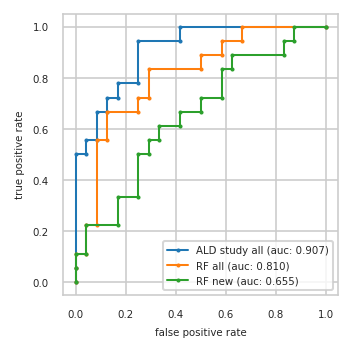

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.111  0.000 0.111
3          0.042 0.500  0.042 0.111  0.042 0.111
4          0.042 0.556  0.042 0.222  0.042 0.222
5          0.083 0.556  0.083 0.222  0.167 0.222
6          0.083 0.667  0.083 0.556  0.167 0.333
7          0.125 0.667  0.125 0.556  0.250 0.333
8          0.125 0.722  0.125 0.667  0.250 0.500
9          0.167 0.722  0.250 0.667  0.292 0.500
10         0.167 0.778  0.250 0.722  0.292 0.556
11         0.250 0.778  0.292 0.722  0.333 0.556
12         0.250 0.944  0.292 0.833  0.333 0.611
13         0.417 0.944  0.500 0.833  0.417 0.611
14         0.417 1.000  0.500 0.889  0.417 0.667
15         1.000 1.000  0.583 0.889  0.500 0.667
16           NaN   NaN  0.583 0.944  0.500 0.722
17           NaN   NaN  0.667 0.944  0.583 0.722
18           NaN   NaN  0.667 1.000  0.583 0.833
19           NaN   NaN  1.000 1.000  0.625 0.833
20           NaN   NaN    NaN   NaN  0.625 0.889
21           NaN   NaN    NaN   NaN  0.833 0.889
22           NaN   NaN    NaN   NaN  0.833 0.944
23           NaN   NaN    NaN   NaN  0.875 0.944
24           NaN   NaN    NaN   NaN  0.875 1.000
25           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P01701,P60709;P63261,G3V295;G3V3I1;G3V5Z7;P60900
2,P04114,C9JIZ6;P07602;P07602-2;P07602-3,P42262;P42262-2;P42262-3
3,Q8NCL4,F8WE04;P04792,P31150
4,P61981,P10636-2;P10636-6,P31321
5,P09960;P09960-4,P04075,A0A075B7B8
6,Q9Y2T3;Q9Y2T3-3,P14174,Q96GD0
7,P04075,P61981,J3KSJ8;Q9UD71;Q9UD71-2
8,P14174,P25189;P25189-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


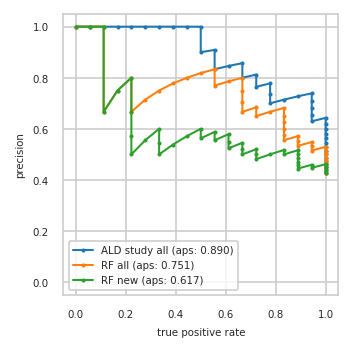

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.533 0.889     0.500 0.833
13         0.621 1.000     0.552 0.889     0.517 0.833
14         0.643 1.000     0.571 0.889     0.500 0.778
15         0.630 0.944     0.556 0.833     0.481 0.722
16         0.654 0.944     0.577 0.833     0.500 0.722
17         0.680 0.944     0.600 0.833     0.520 0.722
18         0.708 0.944     0.625 0.833     0.500 0.667
19         0.739 0.944     0.652 0.833     0.522 0.667
20         0.727 0.889     0.682 0.833     0.545 0.667
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.833 0.556     0.500 0.333
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.750 0.333     0.500 0.222
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.667 0.222     0.667 0.222
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


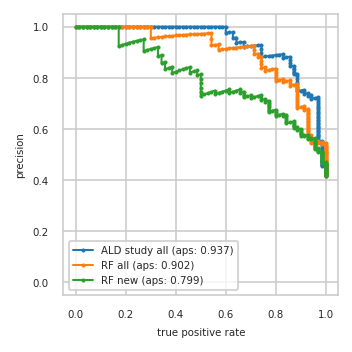

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


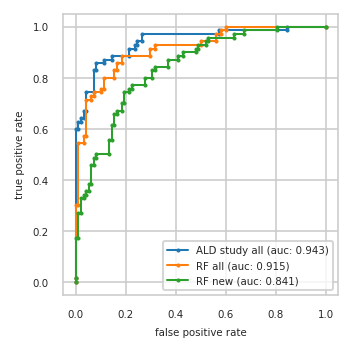

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}